In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
from numpy import sin, cos, heaviside
import os
import sys

sys.path.append("C:\\Users\\Sam Yu\\Documents\\GitHub\\LiquidCrystals\\src")

from LiquidCrystalSystem import LCSystem
from interactions import compute_ellipse_line_intersection

In [2]:
def get_config(r):
    
    if r == 0:
        particle_no_index = 3
        confinement = "Circle"
    else:
        particle_no_index = 4
        confinement = "Annulus"
    
    config = {"R": 25,
              "r": r,
              "b": 5,
              "a": 0.25,
              "confinement": confinement,
              "datasets_path": f"C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\datasets\\r={r}",
              "vis_path": f"C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\visualizations\\r={r}",
              "particle_no_index": particle_no_index}
    
    return config

run_config = get_config(r=0)

print(f"{run_config}\n")

globals().update(run_config)
    
# particle numbers
Ns = sorted([int(_path_.split("_")[particle_no_index]) for _path_ in os.listdir(datasets_path)])

print(f"Particle numbers: {Ns}")

{'R': 25, 'r': 0, 'b': 5, 'a': 0.25, 'confinement': 'Circle', 'datasets_path': 'C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\datasets\\r=0', 'vis_path': 'C:\\Users\\Sam Yu\\Desktop\\School\\4A\\Phys_437A_Research_Project\\visualizations\\r=0', 'particle_no_index': 3}

Particle numbers: [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200]


In [32]:
systems = dict()

for _path_ in os.listdir(datasets_path):
    
    full_path = os.path.join(datasets_path, _path_, 'instanceRun')
    
    # Simulation summary notes exists
    if os.path.exists(os.path.join(full_path, f"MonteCarlo_{confinement}_SimNotes.txt")):
        
        lc = LCSystem(lc_data_path=full_path, confinement=confinement)
        num_of_particles = lc.sim_params['# of Ellipse']
        systems[num_of_particles] = lc
    
    # Simulation summary notes DNE
    else:
        
        lc = LCSystem(lc_data_path=full_path, confinement=confinement)
        lc.sim_params["R"] = R
        lc.sim_params["r"] = r
        lc.sim_params["Semi Major Axis"] = b
        lc.sim_params["Semi Minor Axis"] = a
        
        num_of_particles = lc.sim_params["# of Ellipse"]
        
        systems[num_of_particles] = lc

# remove outliers
#systems = {N:systems[N] for N in systems.keys() if N > 65 and N < 210}

for N in sorted(list(systems.keys())):
    print(f"Particle number: {N}, max step: {max(systems[N].snapshots.keys())}")

Particle number: 20, max step: 2000000.0
Particle number: 25, max step: 2000000.0
Particle number: 30, max step: 2000000.0
Particle number: 35, max step: 2000000.0
Particle number: 40, max step: 2000000.0
Particle number: 45, max step: 2000000.0
Particle number: 50, max step: 2000000.0
Particle number: 55, max step: 2000000.0
Particle number: 60, max step: 2000000.0
Particle number: 65, max step: 2000000.0
Particle number: 70, max step: 2000000.0
Particle number: 75, max step: 2000000.0
Particle number: 80, max step: 2000000.0
Particle number: 85, max step: 2000000.0
Particle number: 90, max step: 2000000.0
Particle number: 95, max step: 2000000.0
Particle number: 100, max step: 2000000.0
Particle number: 105, max step: 2000000.0
Particle number: 110, max step: 2000000.0
Particle number: 115, max step: 2000000.0
Particle number: 120, max step: 2000000.0
Particle number: 125, max step: 2000000.0
Particle number: 130, max step: 2000000.0
Particle number: 135, max step: 2000000.0
Particle

In [3]:
def sample_on_annulus(num_points, r1, r2, t1=0, t2=2*np.pi):
    
    unif = np.random.uniform(low=0, high=1, size=num_points)
    
    # polar coords
    r = np.sqrt((r2**2 - r1**2)*unif + r1**2)
    t = np.random.uniform(low=t1, high=t2, size=num_points)
    
    # convert to cartesian
    x = r * cos(t)
    y = r * sin(t)
    
    return x, y

def naive_sampling(num_points, r1, r2, t1=0, t2=2*np.pi):
    
    # polar coords
    r = np.random.uniform(low=r1, high=r2, size=num_points)
    t = np.random.uniform(low=t1, high=t2, size=num_points)
    
    # convert to cartesian
    x = r * cos(t)
    y = r * sin(t)
    
    return x, y
    
def calculate_local_density(pos_array, inner_radius, outer_radius, a, b, theta_divs=25, r_divs=25):
    
    # number of points per stratified sample
    thetas, tstep = np.linspace(0, 2*np.pi, num=theta_divs, endpoint=False, retstep=True)
    radii, rstep = np.linspace(inner_radius, outer_radius, num=r_divs, endpoint=False, retstep=True)
    
    count = 0
    total_points = 0
    
    for r1 in radii:
        r2 = r1 + rstep
        
        for t1 in thetas:
            t2 = t1 + tstep
            
            
            # scale the number of sampled points with rough radial distance of segment
            f = 120
            n = int(np.ceil(f*((r1 + r2) / 2)))
            # generate sampled points over segment bounded: r1 < r < r2, t1 < t < t2
            xs, ys = sample_on_annulus(n, r1, r2, t1, t2)
            
            total_points += n
            
            # check which points fall within an ellipse
            for ellipse_pos in pos_array:
                
                xc, yc, t = ellipse_pos
                point_check = lambda xp, yp: 1 - heaviside((cos(t)*(xp-xc)-sin(t)*(yp-yc))**2/a**2
                                                            + (sin(t)*(xp-xc)+cos(t)*(yp-yc))**2/b**2
                                                            - 1, 1)
                count += sum(point_check(xs, ys))
    
    return count / total_points

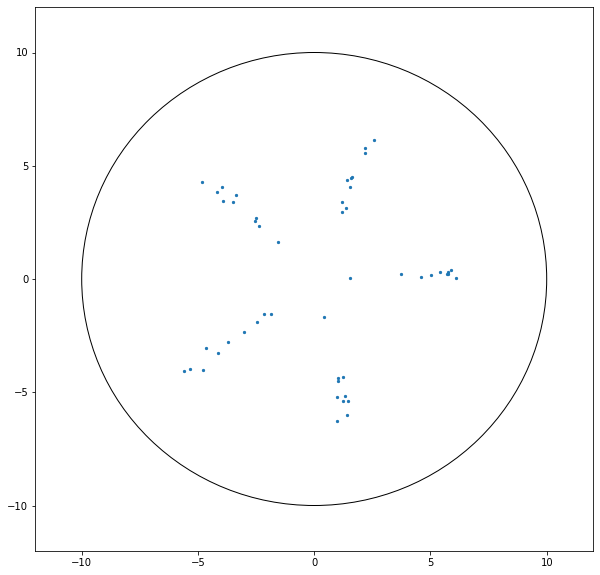

1.5452423292174364,0.02593218915670615
5.743054466201835,0.30938314167083225
3.7265766075534055,0.20225103361392968
5.773483517118837,0.24137802878734
5.018237084150768,0.17448477586421168
-2.1562830826409747,-1.5521675068892689
-4.635097064624172,-3.0447990985685482
-3.021572961647384,-2.3242122660487206
-4.122561428523646,-3.2554956154214145
-1.8757124254747324,-1.5464022259426908
1.5313588066586519,4.0640317280428775
1.1747358406830495,3.407030766275578
1.2018231371446888,2.9609237888467286
2.1955270030466347,5.549472294106053
1.378785620298246,3.1368538824933734
1.4748276870081265,-5.399848671725712
1.0337954383662369,-4.502636408954373
0.43443372457426216,-1.6957271317250364
1.319817831862162,-5.162153398194092
0.9985173019737241,-5.192226572377421
-3.5006217611726367,3.3825462955321592
-3.90320354125374,3.459624402096459
-2.5330971218509064,2.5452033232667612
-2.3727644939884813,2.3303931075235806
-3.967125608142985,4.069037853713305
6.10448310364941,0.033897639104793126
5.720323

In [56]:
# try to replicate a 5-fold symmetry center of mass distribution
r_quadrants = 3
t_quadrants = 50
r_div, r_step = np.linspace(0, 10, r_quadrants, retstep=True)
t_div, t_step = np.linspace(0, 2*np.pi, t_quadrants, retstep=True)

all_x = []
all_y = []
all_r = []
all_t = []
for r1 in range(1, r_quadrants):
    for t1 in range(0, t_quadrants, 10):
        r2 = r1 + r_step
        t2 = t1 + t_step
        x, y = sample_on_annulus(5, r1, r2, t1, t2)
        r = np.sqrt(x**2 + y**2)
        t = np.arctan2(y, x)
        all_x += list(x)
        all_y += list(y)
        all_r += list(r)
        all_t += list(t)

outer = plt.Circle((0,0), radius=10, color="black", fill=False)
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot()
ax.add_patch(outer)
ax.scatter(all_x, all_y, s=5)
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)

plt.show()

for i in range(len(all_x)):
    print(f"{all_x[i]},{all_y[i]}")

Semi-major axis: 5.0
Semi-minor axis: 0.25
Outer radius: 25.0
Inner radius: 0
Total number of ellipses: 80

Calculation time: 13.320364200000768 seconds
Estimated area fraction: 0.1574368
True area fraction: 0.16
Percent error: 1.6020000000000096% 


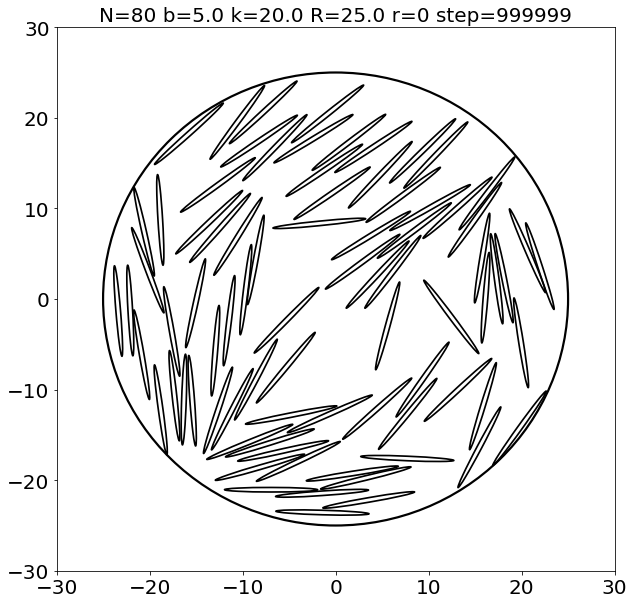

In [76]:
import time

start = time.perf_counter()

test_lc_system = systems[80]

ap = test_lc_system.sim_params["Semi Major Axis"]
bp = test_lc_system.sim_params["Semi Minor Axis"]
Rp = test_lc_system.sim_params["R"]
rp = test_lc_system.sim_params["r"]
N = test_lc_system.sim_params["# of Ellipse"]

print(f"Semi-major axis: {ap}")
print(f"Semi-minor axis: {bp}")
print(f"Outer radius: {Rp}")
print(f"Inner radius: {rp}")
print(f"Total number of ellipses: {N}")
print("")

pos_array = test_lc_system.snapshots[999999]

estimated = calculate_local_density(pos_array=pos_array,
                                    a=ap, 
                                    b=bp,
                                    inner_radius=rp,
                                    outer_radius=Rp)

sys_fig = test_lc_system.plot_snapshot(999999)

true = N * ap * bp / (Rp**2 - rp**2)

print(f"Calculation time: {time.perf_counter() - start} seconds")
print(f"Estimated area fraction: {estimated}")
print(f"True area fraction: {true}")
print(f"Percent error: {np.abs(estimated-true)*100/true}% ")

$\text{Error %}  = \frac{|\text{true} - \text{estimate}|}{\text{true}} \times 100\%$

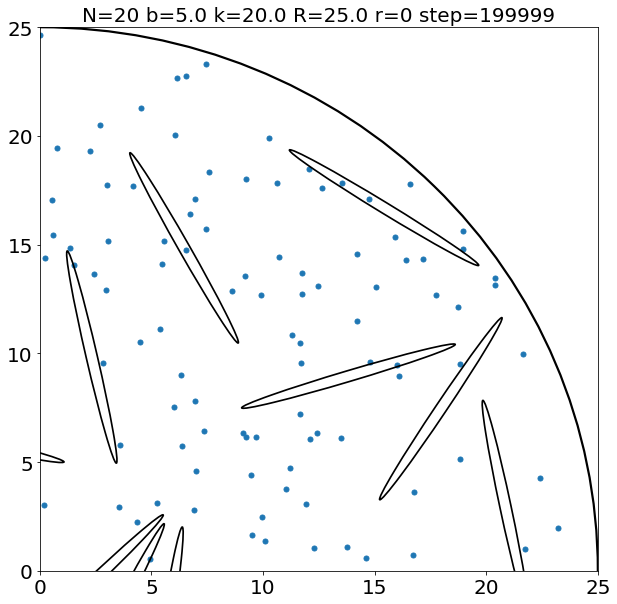

In [8]:
fig = test_lc_system.plot_snapshot(199999)
ax = fig.axes[0]

ax.set_xlim([0, 25])
ax.set_ylim([0, 25])

xs, ys = sample_on_annulus(100, r1=0, r2=25, t1=0, t2=np.pi/2)

ax.scatter(xs, ys, s=25)

In [ ]:
errors = []
for i in range(20):
    estimated = calculate_local_density(pos_array=pos_array,
                                    a=ap, 
                                    b=bp,
                                    f=1,
                                    inner_radius=rp,
                                    outer_radius=Rp)
    errors.append(abs(estimated-true)*100/true)

print(errors)
np.mean(errors)

C:\Users\SAMYU~1\AppData\Local\Temp/ipykernel_57604/1053652697.py:25: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


Text(0, 0.5, 'Mean S(q) cross-section')

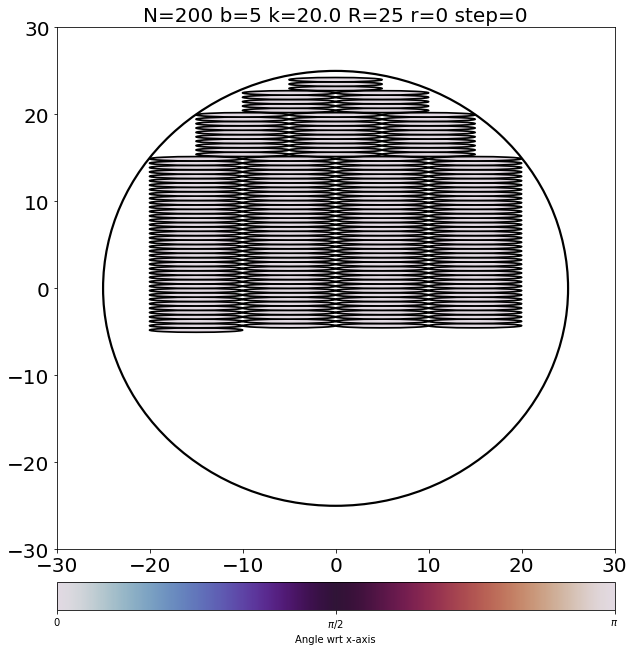

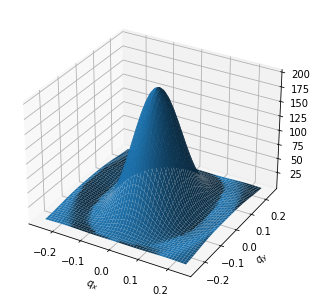

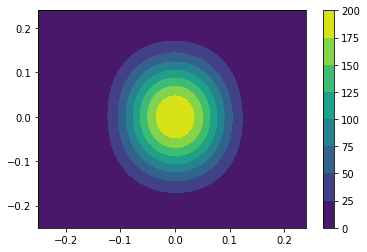

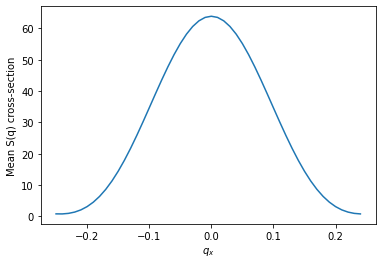

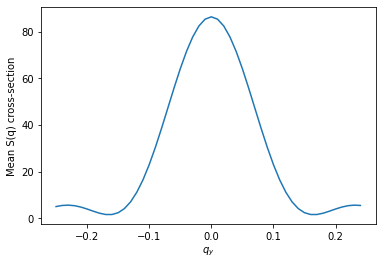

In [13]:
from mpl_toolkits.mplot3d import Axes3D

step = 0
system_size = 200

pos_array = systems[system_size].snapshots[step]

inp_arr = np.arange(-0.25, 0.25, 0.01)
qx, qy = np.meshgrid(inp_arr, inp_arr)

N = len(pos_array)

structure_factor = np.zeros_like(qx).astype("complex128")

for x1, y1, _ in pos_array:
    for x2, y2, _ in pos_array:
        q_dot_r = qx * (x1 - x2) + qy * (y1 - y2)
        structure_factor += np.exp(-1j * q_dot_r)
        
structure_factor = np.real(structure_factor) / N

fig3 = systems[system_size].plot_snapshot(step, color_angles=True)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(qx, qy, structure_factor)
plt.xlabel(r"$q_x$")
plt.ylabel(r"$q_y$")

fig2, ax2 = plt.subplots()
cf = ax2.contourf(qx, qy, structure_factor)
plt.colorbar(cf)

fig3, ax3 = plt.subplots()
sf_x = np.mean(structure_factor, axis=1)
ax3.plot(inp_arr, sf_x)
ax3.set_xlabel(r"$q_x$")
ax3.set_ylabel("Mean S(q) cross-section")

fig4, ax4 = plt.subplots()
sf_y = np.mean(structure_factor, axis=0)
ax4.plot(inp_arr, sf_y)
ax4.set_xlabel(r"$q_y$")
ax4.set_ylabel("Mean S(q) cross-section")

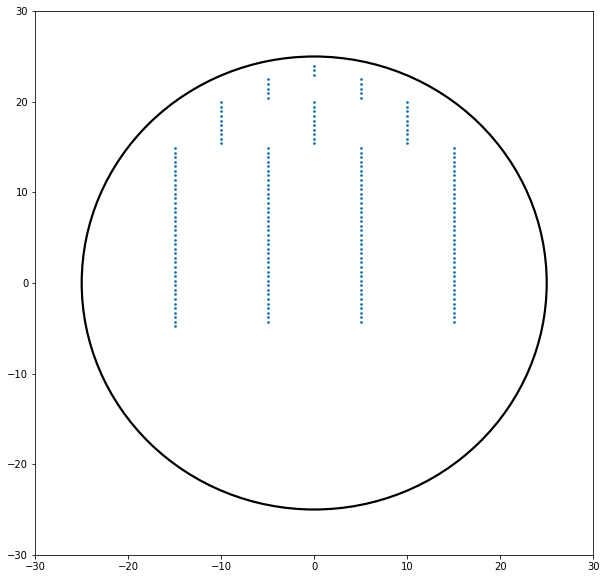

In [17]:
fig5, ax5 = plt.subplots()
ax5.scatter(pos_array[:,0], pos_array[:,1], s=3)
ax5.add_patch(plt.Circle((0,0), 25, color='black', fill=False, linewidth=2.2))
ax5.set_xlim([-30, 30])
ax5.set_ylim([-30, 30])
fig5.set_size_inches(10, 10)

In [ ]:
import time
start = time.perf_counter()

# total number of particles
system_size = 200
dr = 0.05
r_cutoff = 2
rs =  np.arange(0.001, r_cutoff, dr)

print(f"Total number: {N}")
print(f"long axis: {b}")
print(f"short axis: {a}")

# use time steps between 1e6 and 1.5e6
snapshots = systems[system_size].snapshots
possible_steps = [s for s in snapshots.keys() if 1e6-1 <= s <= 1.5e6]

pair_dist_func = []

# for possible distances
for r in rs:
    
    for_time_avg = []
    # for each Monte Carlo step -- averaging
    for step in possible_steps:
        
        pos_array = snapshots[step][:, :2]
        pairwise = distance_matrix(pos_array, pos_array)
        contained_in_r = np.sum(((r < pairwise) & (pairwise < r+dr)).astype(int))
        for_time_avg.append(contained_in_r)

    norm_factor = (R**2)/(2*r*dr*system_size**2)
    g_r = np.mean(for_time_avg) * norm_factor
    
    pair_dist_func.append(g_r)
    
print(f"Calculation time: {time.perf_counter() - start} seconds")

In [ ]:
fig2, ax2 = plt.subplots()
ax2.scatter(rs, pair_dist_func)
ax2.plot(rs, pair_dist_func)
ax2.axhline(1, linestyle='--')
ax2.axvline(2*a, linestyle='--', label="short length", color='orange')
ax2.legend()

fig3, ax3 = plt.subplots()
ax3.hist(pairwise.flatten())

In [ ]:
fig = systems[system_size].plot_snapshot(999999, color_angles=True)

In [ ]:
print(f"Total number: {N}")
print(f"long axis: {b}")
print(f"short axis: {a}")

N = len(pos_array)
dr = 0.1
r_cutoff = 10
rs =  np.arange(0.001, r_cutoff, dr)

import time
start = time.perf_counter()

# total number of particles
system_size = 200

# use time steps between 1e6 and 1.5e6
snapshots = systems[system_size].snapshots
possible_steps = [s for s in snapshots.keys() if 1e6-1 <= s <= 1.5e6]

angular_corr_function = []
for r in rs:
    for step in possible_steps:
        # for averaging over all snapshots
        for_time_avg = []
        # spatial (x,y) coordinates for particles in snapshot
        pos_array = snapshots[step]
        ref_particles_sum = 0
        # loop over all particles as the reference particle
        for ref_coord in pos_array:
            pair_distances = np.linalg.norm(pos_array[:,:2] - ref_coord[:2], axis=1)
            # count the number of particles that lie in a circle shell (r, r+dr) centered on ref particle
            angular_diffs = [cos(ref_coord[-1]) - cos(coords[i][-1]) for i, r_jk in enumerate(pair_distances) if r < r_jk < r+dr]
            contained_in_r = np.mean(angular_diffs)
            ref_particles_sum += contained_in_r
        
        for_time_avg.append(ref_particles_sum)

    norm_factor = (R**2)/(2*r*dr*N*(N-1))
    g2_r = np.mean(for_time_avg) * norm_factor
    
    angular_corr_function.append(g2_r)
    
print(f"Calculation time: {time.perf_counter() - start}")

In [18]:
print(len(pos_array))

200


(-12.0, 12.0)

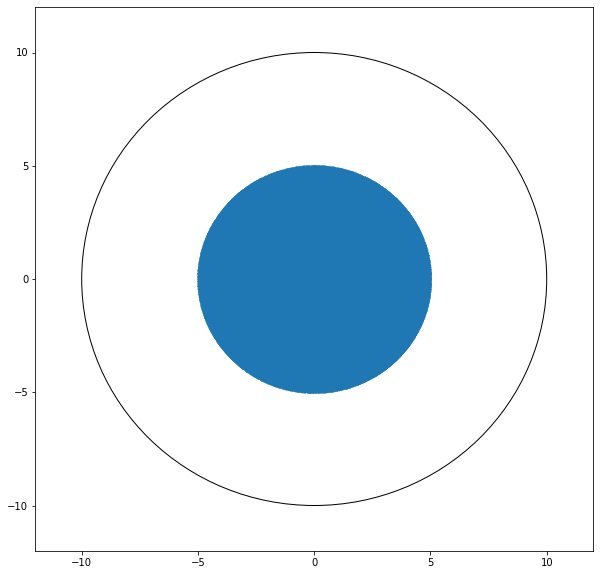

In [10]:
x, y = sample_on_annulus(1000000, 0, 5, 0, 2*np.pi)

outer = plt.Circle((0,0), radius=10, color="black", fill=False)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.add_patch(outer)
ax.scatter(x, y, s=0.1)
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)

(-12.0, 12.0)

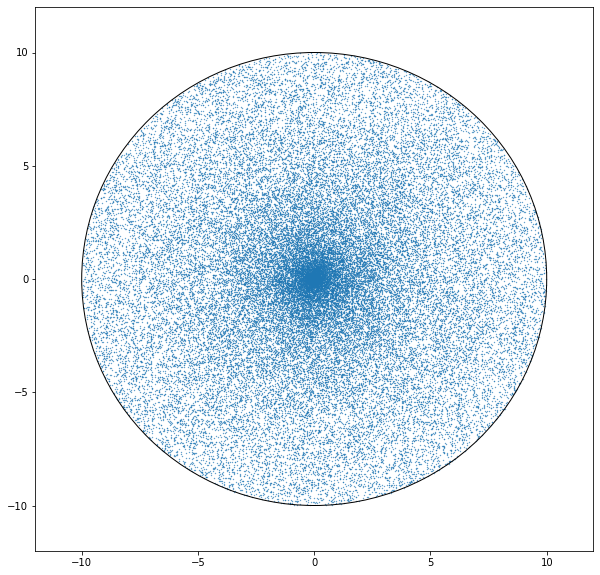

In [4]:
fig2, ax2 = plt.subplots()
fig2.set_size_inches(10, 10)
ax2.add_patch(plt.Circle((0,0), radius=10, color="black", fill=False))

xp, yp = naive_sampling(50000, 0, 10)
ax2.scatter(xp, yp, s=0.1)
ax2.set_xlim(-12, 12)
ax2.set_ylim(-12, 12)